In [2]:
# ------import------
import torch.nn as nn
import torch
import sys, os
sys.path.append(os.pardir)
from torchOptics import optics as tt
from torchOptics import models as tm
from torchOptics import quantum as qt
import numpy as np
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
from tqdm import tqdm

In [3]:
meta = {'wl':(638e-9, 515e-9, 450e-9), 'dx': (6.3e-6, 6.3e-6)}

In [30]:
###target image (Gaussian)

size = 512  #배열 크기
sigma = 10  #표준편차
timg = np.zeros((size, size), dtype=np.float64)
amplitude = 1

#gaussian 추가
def add_gaussian(x1, y1, sigma, amplitude=amplitude):
    y, x = np.indices((size, size))
    x1 = float(x1)
    y1 = float(y1)
    gaussian = amplitude * np.exp(-((x-x1)**2+(y-y1)**2)/(2*sigma**2))
    return gaussian

centers = [(200, 200), (200, 350), (350, 350), (350, 200)]
for center in centers:
    timg += add_gaussian(center[0], center[1], sigma)

timg = tt.Tensor(timg, meta=meta)

In [31]:
def GS_algorithm (img, max_iter) :
    #initial = SLM plane
    #final = lens focal plane
    h, w = img.size()
    initial_phase = torch.tensor(2*np.pi*np.random.rand(h, w)-np.pi).cuda()
    final_phase = torch.ones((h,w)).cuda()
    initial_amplitude = torch.sqrt(img).cuda()
    final_amplitude = torch.ones((h,w)).cuda()

    U_initial = tt.Tensor(initial_amplitude*torch.exp(1j*initial_phase), meta=meta)

    pbar = tqdm(range(max_iter))

    for i in pbar :
        
        U_final = tt.fft(U_initial)
        final_phase = torch.angle(U_final)
        U_final = final_amplitude*torch.exp(1j*final_phase)
        U_initial = tt.ifft(U_final)
        initial_phase = torch.angle(U_initial)
        U_initial = initial_amplitude*torch.exp(1j*initial_phase)

    Final_phase = final_phase
    return Final_phase

In [32]:
phase = GS_algorithm(timg, 2000)
potential = tt.Tensor(tt.ifft(torch.exp(1j*phase)), meta=meta)

100%|██████████| 2000/2000 [00:00<00:00, 2219.85it/s]


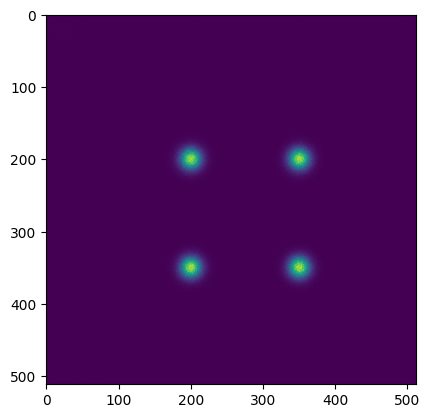

In [33]:
plt.imshow(np.abs(potential.cpu())**2)
plt.show()

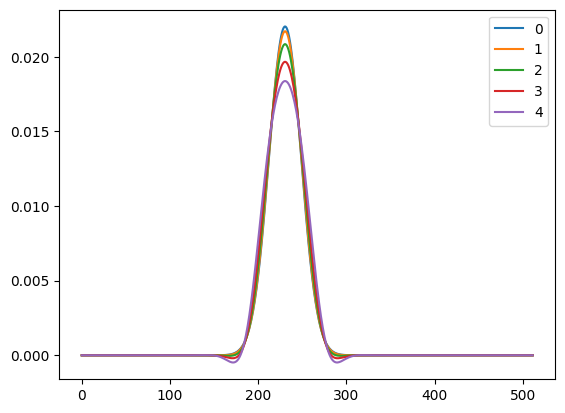

In [39]:
if __name__=='__main__':
    device = 'cpu'
    x = qt.position(-5,5,512).to(device)
    p = qt.momentum(x)
    H = p@p/2 - potential.to(device).to(dtype=torch.float64).abs()**2

    L, V = torch.linalg.eigh(H)

    psi = qt.gaussian(x.diag(), x0=-0.5, w=0.5, A=1).to(dtype=torch.float64)
    psi = psi/psi.abs().sum()

    pred = qt.schrodinger(H, psi, torch.linspace(0, 0.1, 5))

    for idx,pp in enumerate(pred):
        plt.plot(pp.detach().cpu().real, label=idx)
    plt.legend()
    plt.show()

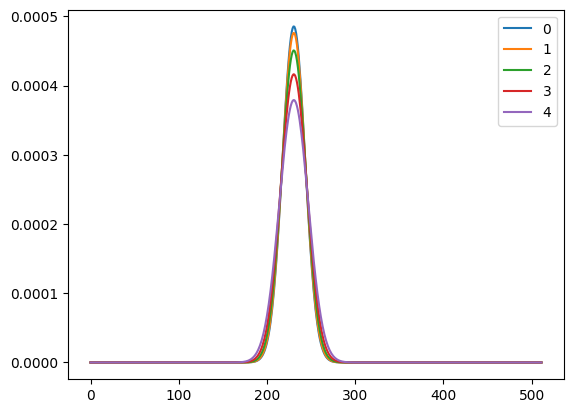

In [40]:
for idx,pp in enumerate(pred.abs()**2):
        plt.plot(pp.detach().cpu().real, label=idx)
plt.legend()
plt.show()

In [36]:
np.argmax(pred.cpu())

tensor(230)